<a href="https://colab.research.google.com/github/lucas6028/machine_learning/blob/main/CNN/training/sports_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import kagglehub

from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder
from google.colab import drive
from tqdm.auto import tqdm
from PIL import Image

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Download latest version
# https://www.kaggle.com/datasets/gpiosenka/sports-classification
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9


## Use TensorFlow ImageDataGenerator for Image Loading and Augmentation

Use ImageDataGenerator to preprocess the images (e.g., rescale, rotate, flip) and create generators for training and validation data:

In [2]:
train_tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to RGB
    transforms.RandomResizedCrop(size=(224, 224), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

## Define the CNN Model

In [3]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 64
train_dir = '/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/train'
test_dir = '/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/test'
valid_dir = '/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/valid'

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder(train_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder(valid_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = DatasetFolder(test_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Model

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # Convolutional layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 14 * 14, 256),  # Adjusted input for 224x224 images
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 100)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x


## Training

In [5]:
def get_pseudo_labels(dataset, model, threshold=0.65):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    for batch in tqdm(data_loader):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # ---------- TODO ----------
        # Filter the data and construct a new dataset.

    # # Turn off the eval mode.
    model.train()
    return dataset

In [6]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 5

# Whether to do semi-supervised learning.
do_semi = False

# Initialize lists to store the loss and accuracy values for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(n_epochs):
    # # ---------- TODO ----------
    # # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    # if do_semi:
    #     # Obtain pseudo-labels for unlabeled data using trained model.
    #     pseudo_set = get_pseudo_labels(unlabeled_set, model)

    #     # Construct a new dataset and a data loader for training.
    #     # This is used in semi-supervised learning only.
    #     concat_dataset = ConcatDataset([train_set, pseudo_set])
    #     train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # Compute average training loss and accuracy for the epoch
    avg_train_loss = sum(train_loss) / len(train_loss)
    avg_train_acc = sum(train_accs) / len(train_accs)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {avg_train_loss:.5f}, acc = {avg_train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # Compute average validation loss and accuracy for the epoch
    avg_valid_loss = sum(valid_loss) / len(valid_loss)
    avg_valid_acc = sum(valid_accs) / len(valid_accs)
    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(avg_valid_acc)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {avg_valid_loss:.5f}, acc = {avg_valid_acc:.5f}")

  0%|          | 0/211 [00:00<?, ?it/s]

[ Train | 001/005 ] loss = 4.43607, acc = 0.03400


  0%|          | 0/8 [00:00<?, ?it/s]

[ Valid | 001/005 ] loss = 5.18189, acc = 0.00977


  0%|          | 0/211 [00:00<?, ?it/s]

[ Train | 002/005 ] loss = 4.13057, acc = 0.06446


  0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240>Exception ignored in: 

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240>

Traceback (most recent call last):
Trace

[ Valid | 002/005 ] loss = 5.95932, acc = 0.00977


  0%|          | 0/211 [00:00<?, ?it/s]

[ Train | 003/005 ] loss = 3.95598, acc = 0.08947


  0%|          | 0/8 [00:00<?, ?it/s]

[ Valid | 003/005 ] loss = 6.22307, acc = 0.00977


  0%|          | 0/211 [00:00<?, ?it/s]

[ Train | 004/005 ] loss = 3.80731, acc = 0.11733


  0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff59040d240>  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive


    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataload

[ Valid | 004/005 ] loss = 8.17625, acc = 0.00977


  0%|          | 0/211 [00:00<?, ?it/s]

[ Train | 005/005 ] loss = 3.64724, acc = 0.13847


  0%|          | 0/8 [00:00<?, ?it/s]

[ Valid | 005/005 ] loss = 7.78866, acc = 0.01758


## Testing

In [7]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

  0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

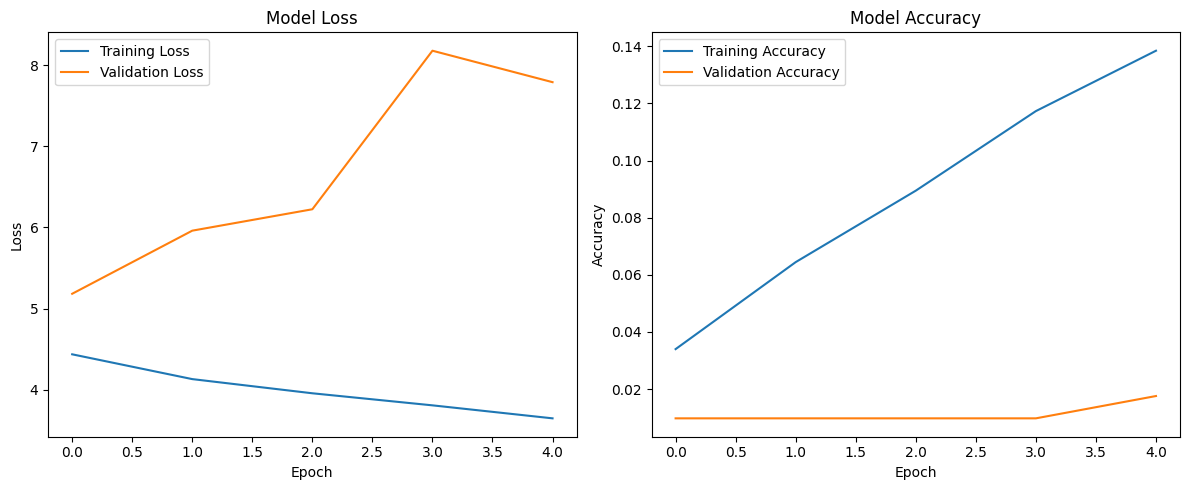

In [11]:
# Ensure data is on the CPU before plotting
train_losses = [loss.cpu() if hasattr(loss, 'cpu') else loss for loss in train_losses]
valid_losses = [loss.cpu() if hasattr(loss, 'cpu') else loss for loss in valid_losses]
train_accuracies = [acc.cpu() if hasattr(acc, 'cpu') else acc for acc in train_accuracies]
valid_accuracies = [acc.cpu() if hasattr(acc, 'cpu') else acc for acc in valid_accuracies]

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Store the model

In [12]:
# drive.mount('/content/drive')

# Save TensorFlow model to Google Drive
# model.save('/content/drive/MyDrive/sports_model.h5')